In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from IPython.display import display
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, roc_auc_score 

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
class Models:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def calibracion(self, predicciones, y, bins, plot = True):
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
        grouped = df_calibracion.groupby('bins').mean()
        if plot:
            plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'blue')
            plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'red')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            plt.legend()
            plt.grid()    

    def linear_regression(self, plot = True):
        model = LinearRegression().fit(self.X_train, self.y_train)
        predicciones = model.predict(self.X_test)
        r2 = r2_score(self.y_test, predicciones)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10, plot)
        return r2
    
    def linear_ridge(self, plot = True):
        model = Ridge().fit(self.X_train, self.y_train)
        predicciones = model.predict(self.X_test)
        r2 = r2_score(self.y_test, predicciones)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10, plot)
        return r2

    def linear_lasso(self, plot = True):
        model = Lasso().fit(self.X_train, self.y_train)
        predicciones = model.predict(self.X_test)
        r2 = r2_score(self.y_test, predicciones)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10, plot)
        return r2
    
    def polinomial_regression(self, degree=2, plot = True):
        """
        Por defecto usa Lasso para regularización
        """
        X_scaled = StandardScaler().fit_transform(self.X)
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X_scaled)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, self.y, test_size=0.2, random_state=42)
        model = Lasso().fit(X_train, y_train)
        predicciones = model.predict(X_test)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10, plot)
        r2 = r2_score(y_test, predicciones)
        return r2
    
    def knn(self, plot = True):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)

        r2s = [r2_score(self.y_test, KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, self.y_train).predict(X_test_scaled)) for i in range(1, 50)]

        r2s_df = pd.DataFrame({
            'nn': range(1, 50),
            'r2': r2s
        })

        opt_nn = r2s_df[r2s_df['r2'] == r2s_df['r2'].max()]['nn'].values[0]
        model = KNeighborsRegressor(n_neighbors=opt_nn).fit(X_train_scaled, self.y_train)
        predicciones = model.predict(X_test_scaled)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10, plot)
        return r2s_df[r2s_df['r2'] == r2s_df['r2'].max()]
    
    def run_models(self):
        modelos = [
            'Regresión Lineal',
            'Regresión Ridge',
            'Regresión Lasso',
            'Regresión Polinomial (grado 2)',
            'Regresión Polinomial (grado 3)',
            'KNN'
        ]
        r2s = [
            self.linear_regression(plot=False),
            self.linear_ridge(plot=False),
            self.linear_lasso(plot=False),
            self.polinomial_regression(2,plot=False),
            self.polinomial_regression(2,plot=False),
            self.knn(plot=False)['r2'].values[0]
        ]
        return pd.DataFrame({
            'Modelo': modelos,
            'R2': r2s
        })

In [4]:
X = data.copy()
X = data.drop(columns=[target])
y = data[target]

In [5]:
Models(X, y).run_models()

,Modelo,R2
0,Regresión Lineal,0.290745
1,Regresión Ridge,0.291855
2,Regresión Lasso,0.294198
3,Regresión Polinomial (grado 2),0.215310
4,Regresión Polinomial (grado 3),0.215310
5,KNN,0.305726


In [30]:
class ClassificationModels:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0)

    def histograma(self, probabilidades, y_test):
        juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': probabilidades
        })

        plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1')
        plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0')
        plt.title(f'Histograma de probabilidades')
        plt.legend()
        plt.show()

    def logistic_regression(self):
        model = linear_model.LogisticRegression().fit(self.X_train, self.y_train)
        probabilidades = model.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)


        coeficientes = pd.DataFrame({
            'features': self.X.columns,
            'coeficiente': model.coef_[0]
        })
        display(coeficientes)
        self.histograma(probabilidades, self.y_test)
        return auc
    
    def logistic_regression_poly(self, degree=2):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degree)),
            ('logistic', linear_model.LogisticRegression(penalty='l2'))
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.histograma(probabilidades, self.y_test)
        return auc  

    def discriminant_analysis(self):
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.histograma(probabilidades, self.y_test)
        return auc
    
    def knn_classification(self):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)

        auc = [roc_auc_score(y_score=neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled,self.y_train).predict_proba(X_test_scaled)[:, 1], y_true=self.y_test) for i in range(1,100)]

        knn = pd.DataFrame({
            'nn': range(1,100),
            'auc':auc
        })

        opt_nn = knn[knn['auc']==knn['auc'].max()]['nn'].values[0]
        model = neighbors.KNeighborsClassifier(n_neighbors=opt_nn).fit(X_train_scaled, self.y_train)
        probabilidades = model.predict_proba(X_test_scaled)[:, 1]
        auc = auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)
        self.histograma(probabilidades, self.y_test)
        return knn[knn['auc']==knn['auc'].max()]

In [25]:
df = pd.read_csv('titanic.csv')
df['Pclass'] = df.Pclass.astype(object)
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df, drop_first=True)
df['Age'] = df['Age'].fillna(df.Age.mean())
target = 'Survived'
X = df.copy()
X = df.drop(target, axis=1)
y = df[target]

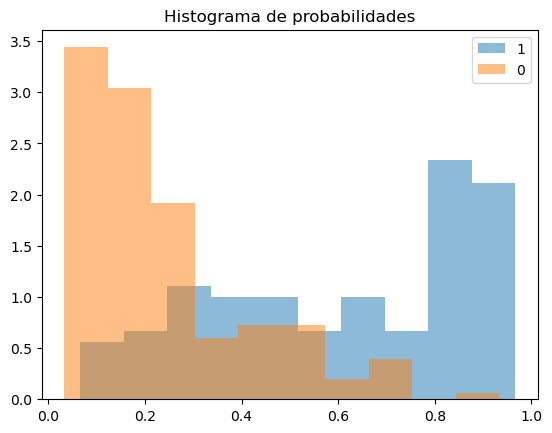

,nn,auc
29,30,0.868155


In [31]:
ClassificationModels(X, y).knn_classification()